In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import shap 
from lightgbm import LGBMRegressor, early_stopping
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [175]:
#Ensure that you adjust this to suit your file name
contracts = pd.read_csv("rental_contracts.csv")

contracts.head()

,Room Title,Property Id,Start Date,End Date,Created Date,Signed Date,Host Name,Host Client Name,Renter Name,Renter Client Name,...,Guest Bathroom,Room Rent,Room Utilities,City,Province,Zip Code,Home Details,Admin Notes,Created At,Updated At
0,Close to all amenities! Close to transit!,29,2025-11-26,2027-11-24,2025-05-16,2025-05-16,Jane Dou,Happipad,Jane Dou,Happipad,...,NaN,850,0.0,Kelowna,BC,V1X7H3,Property Type: Apartment;\nHousehold Items: Co...,NaN,2025-05-16,2025-05-16
1,Close to all amenities! Close to transit!,29,2025-01-01,2025-11-26,2025-05-16,2025-05-16,Jane Dou,Happipad,Jane Dou,Happipad,...,NaN,850,0.0,Kelowna,BC,V1X7H3,Property Type: Apartment;\nHousehold Items: Co...,NaN,2025-05-16,2025-05-16
2,"Large, open-concept, with private bathroom and...",3378,2025-09-01,2025-11-30,2025-05-01,2025-05-01,Jane Dou,Happipad,Jane Dou,Happipad,...,NaN,1000,0.0,Kelowna,BC,V1Y5T1,Property Type: Townhouse;\nFurnishings: Beddin...,NaN,2025-05-01,2025-05-03
3,Room for a UBC student.,815,2025-06-01,2025-09-30,2025-05-01,2025-05-02,Jane Dou,Happipad,Jane Dou,Happipad,...,NaN,525,0.0,Kelowna,BC,V1X2P1,"Property Type: House;\nFurnishings: Desk, Hang...",NaN,2025-05-01,2025-05-04
4,Walkout Basement Accomo in Lakeview Heights wi...,1766,2025-05-01,2025-10-31,2025-04-29,2025-04-29,Jane Dou,Happipad,Jane Dou,Happipad,...,NaN,1025,0.0,West Kelowna,BC,V1Z1W5,Property Type: House;\nFacilities: Common loun...,NaN,2025-04-29,2025-04-29


In [177]:
# Dictionary mapping full province names to abbreviations
province_map = {
    'Alberta': 'AB',
    'British Columbia': 'BC',
    'Manitoba': 'MB',
    'New Brunswick': 'NB',
    'Newfoundland and Labrador': 'NL',
    'Nova Scotia': 'NS',
    'Ontario': 'ON',
    'Prince Edward Island': 'PE',
    'Quebec': 'QC',
    'Saskatchewan': 'SK',
    'Northwest Territories': 'NT',
    'Nunavut': 'NU',
    'Yukon': 'YT'
}

# Add abbreviations to the dictionary so they don't get changed
province_map.update({abbr: abbr for abbr in province_map.values()})

# Standardize all values in the Province column
contracts['Province'] = contracts['Province'].map(province_map)

# Check if there are any unmapped provinces (e.g., typos)
unmapped = contracts[contracts['Province'].isna()]
if not unmapped.empty:
    print(" Unmapped values found in Province column:")
    print(unmapped['Province'].unique())


In [179]:
# Display the unique values of the Province column

print(contracts['Province'].unique())

['BC' 'NS' 'AB' 'ON' 'NB' 'MB']


In [181]:
# Identify all date columns

date_columns = [
    'Start Date', 'End Date', 'Created Date', 'Signed Date',
    'Contract Termination Date', 'Deadline', 'Created At', 'Updated At'
]

# Convert these values to datetimes

for col in date_columns:
    contracts[col] = pd.to_datetime(contracts[col], errors='coerce')

# Check that datatypes were correctly converted 

print(contracts[date_columns].dtypes)


Start Date                   datetime64[ns]
End Date                     datetime64[ns]
Created Date                 datetime64[ns]
Signed Date                  datetime64[ns]
Contract Termination Date    datetime64[ns]
Deadline                     datetime64[ns]
Created At                   datetime64[ns]
Updated At                   datetime64[ns]
dtype: object


In [183]:
# Separate Home Details column into multiple variables 

from sklearn.preprocessing import MultiLabelBinarizer

# Function to extract list-based items from Home Details column
def extract_items(text, label):
    match = pd.Series(text).str.extract(rf'{label}:\s*(.*?);')[0]
    return match.fillna('').str.split(r',\s*')

# Extract the categories into list columns
contracts['Furnishings_list'] = extract_items(contracts['Home Details'], 'Furnishings')
contracts['Safety Features_list'] = extract_items(contracts['Home Details'], 'Safety Features')
contracts['Amenities_list'] = extract_items(contracts['Home Details'], 'Amenities')
contracts['House Rules_list'] = extract_items(contracts['Home Details'], 'House Rules')

# Function to one-hot encode list-based columns
def binarize_column(df, column_name, prefix):
    mlb = MultiLabelBinarizer()
    transformed = pd.DataFrame(
        mlb.fit_transform(df[column_name]),
        columns=[f'{prefix}: {item}' for item in mlb.classes_],
        index=df.index
    )
    return transformed

# One-hot encode each list column
furnishings_ohe = binarize_column(contracts, 'Furnishings_list', 'Furnishing')
safety_ohe = binarize_column(contracts, 'Safety Features_list', 'Safety')
amenities_ohe = binarize_column(contracts, 'Amenities_list', 'Amenity')
rules_ohe = binarize_column(contracts, 'House Rules_list', 'Rule')

# --- Extract single-value fields like 'Bed Type' and 'Property Type'
contracts['Bed Type'] = contracts['Home Details'].str.extract(r'Bed Type:\s*([^;]+)')
contracts['Property Type'] = contracts['Home Details'].str.extract(r'Property Type:\s*([^;]+)')

# Combine one-hot columns with the original DataFrame
contracts = pd.concat([contracts, furnishings_ohe, safety_ohe, amenities_ohe, rules_ohe], axis=1)

# Drop intermediate list columns
contracts.drop(columns=['Furnishings_list', 'Safety Features_list', 'Amenities_list', 'House Rules_list'], inplace=True)





In [185]:
# Remove rows where 'Room Title' contains 'test' or 'demo' (case-insensitive)
contracts = contracts[~contracts['Room Title'].str.contains('test|demo', case=False, na=False)]

# Remove postal code spaces and convert to uppercase
contracts['Zip Code'] = contracts['Zip Code'].str.replace(r'\s+', '', regex=True).str.upper()

# Define a regex pattern for valid Canadian postal codes
postal_code_pattern = r'^[A-Z]\d[A-Z]\d[A-Z]\d$'

# Replace invalid postal codes with NaN
contracts['Zip Code'] = contracts['Zip Code'].where(contracts['Zip Code'].str.match(postal_code_pattern))

num_valid_postal_codes = contracts['Zip Code'].str.match(postal_code_pattern).sum()
print(f"Number of valid postal codes: {num_valid_postal_codes}")

contracts.head(3)

Number of valid postal codes: 592


,Room Title,Property Id,Start Date,End Date,Created Date,Signed Date,Host Name,Host Client Name,Renter Name,Renter Client Name,...,Amenity: Microwave,Amenity: Private entry,Amenity: Stove and oven,Amenity: Street parking,Amenity: Swimming pool,Amenity: Tv,Amenity: Washer,Amenity: Window covering,Amenity: wifi,Rule:
0,Close to all amenities! Close to transit!,29,2025-11-26,2027-11-24,2025-05-16,2025-05-16,Jane Dou,Happipad,Jane Dou,Happipad,...,1,1,1,1,0,1,1,1,1,1
1,Close to all amenities! Close to transit!,29,2025-01-01,2025-11-26,2025-05-16,2025-05-16,Jane Dou,Happipad,Jane Dou,Happipad,...,1,1,1,1,0,1,1,1,1,1
2,"Large, open-concept, with private bathroom and...",3378,2025-09-01,2025-11-30,2025-05-01,2025-05-01,Jane Dou,Happipad,Jane Dou,Happipad,...,1,1,1,1,0,1,1,1,1,1


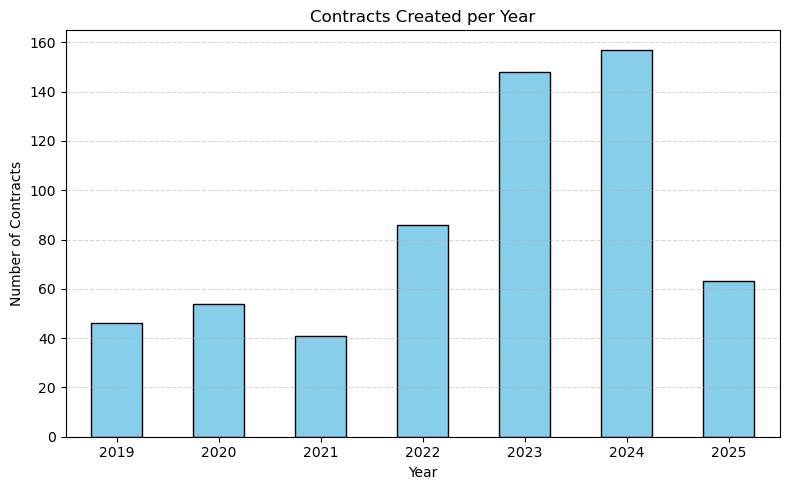

In [187]:
#Investigate how many contracts were created in each year

# Extract year
contracts['Created Year'] = contracts['Created Date'].dt.year

# Count contracts per year
yearly_counts = contracts['Created Year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
yearly_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Contracts Created per Year')
plt.xlabel('Year')
plt.ylabel('Number of Contracts')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



C:\Users\Foste\AppData\Local\Temp\ipykernel_3624\138989318.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


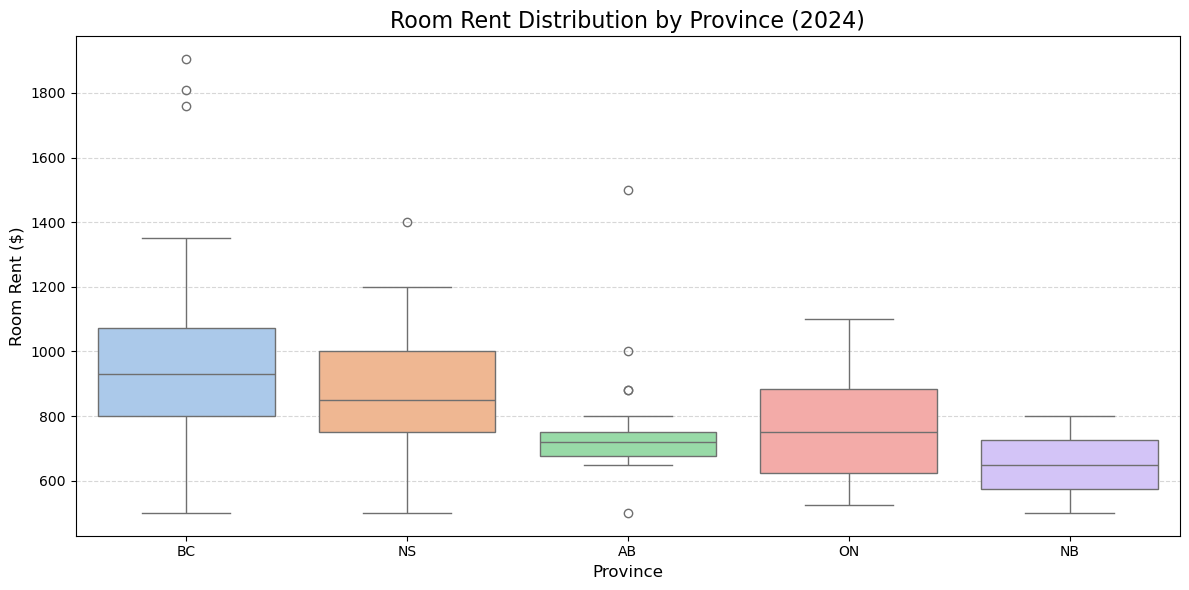

In [189]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter contracts created in 2024
contracts_2024 = contracts[contracts['Created Year'] == 2024].copy()

# Drop rows with missing province or rent
contracts_2024 = contracts_2024.dropna(subset=['Province', 'Room Rent'])

# Sort provinces by number of contracts
province_order = contracts_2024['Province'].value_counts().index

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=contracts_2024,
    x='Province',
    y='Room Rent',
    order=province_order,
    palette='pastel'
)

plt.title('Room Rent Distribution by Province (2024)', fontsize=16)
plt.xlabel('Province', fontsize=12)
plt.ylabel('Room Rent ($)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


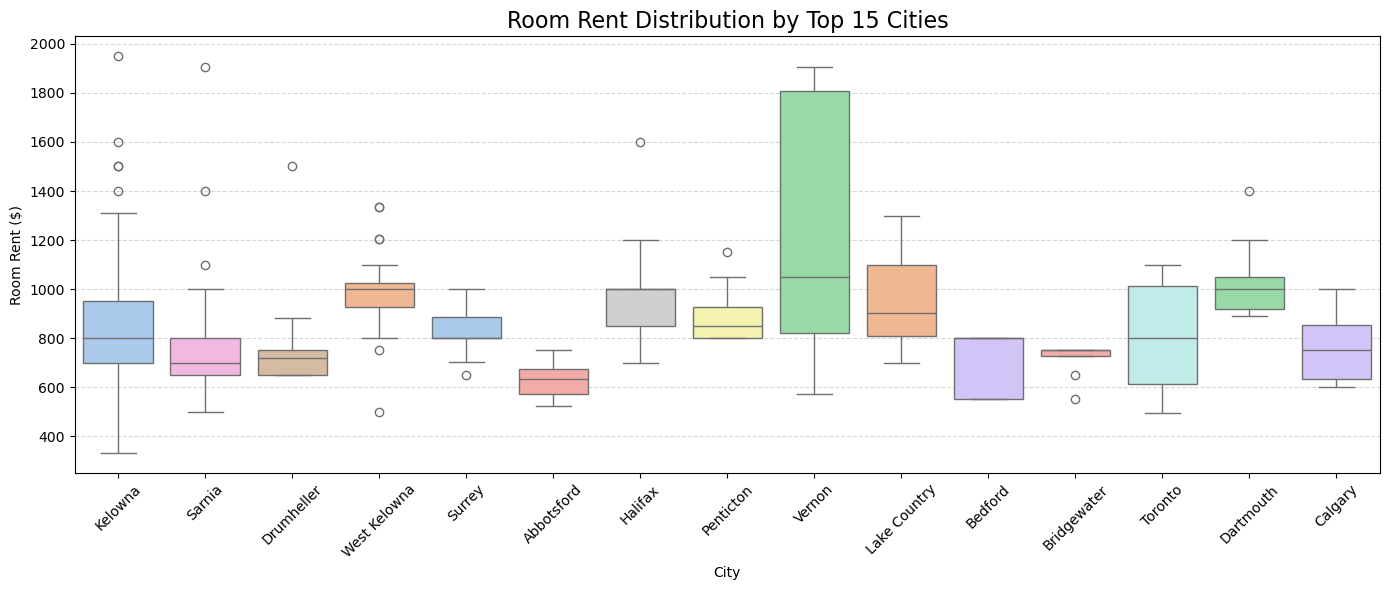

In [191]:

# Get the top 15 cities by number of contracts
top_cities = contracts['City'].value_counts().nlargest(15)

# Filter contracts for only the top 15 cities
contracts_top_cities = contracts[contracts['City'].isin(top_cities.index)]

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=contracts_top_cities,
    x='City',
    y='Room Rent',
    hue='City',
    palette='pastel',
    order=top_cities.index,   # <-- sort by number of contracts
    legend=False
)

plt.title('Room Rent Distribution by Top 15 Cities', fontsize=16)
plt.ylabel('Room Rent ($)')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [193]:
#Create new column for length of contract 

from dateutil.relativedelta import relativedelta

def diff_months_rounded(end, start):
    rd = relativedelta(end, start)
    total_months = rd.years * 12 + rd.months
    # Round up if 15 or more days
    if rd.days >= 15:
        total_months += 1
    return total_months

contracts['Contract Length (months, rounded)'] = contracts.apply(
    lambda row: diff_months_rounded(row['End Date'], row['Start Date']), axis=1
)


In [195]:
contracts['Contract Length (months, rounded)'].head()

0    24
1    11
2     3
3     4
4     6
Name: Contract Length (months, rounded), dtype: int64

In [197]:
contracts['Contract Length (months, rounded)'].value_counts()


Contract Length (months, rounded)
 4     98
 1     76
 2     69
 3     67
 8     51
 6     41
 12    37
 5     35
 7     23
 9     17
 11    15
 0     15
 13    12
 10    10
 17     4
 18     4
 16     4
 24     3
 14     2
 15     2
-1      2
 21     2
 20     1
 19     1
 29     1
 23     1
 26     1
 37     1
Name: count, dtype: int64

In [261]:
# --------- Modeling preparation ------------

# --------- First XGBoost Model ------------
# 1. Define features and target
X = contracts.drop(columns=['Room Rent'])
y = contracts['Room Rent']

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Target encoding for 'City' based on training data
city_target_mean = X_train.join(y_train).groupby('City')['Room Rent'].mean()

X_train['City_TE'] = X_train['City'].map(city_target_mean)
X_test['City_TE'] = X_test['City'].map(city_target_mean)

# Fill unseen cities in test with global mean
global_mean = y_train.mean()
X_test['City_TE'] = X_test['City_TE'].fillna(global_mean)

# 4. One-hot encode 'City' (excluding 'City' since we target encoded it)
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

X_train_ohe = ohe.fit_transform(X_train[['City']])
X_test_ohe = ohe.transform(X_test[['City']])

ohe_columns = ohe.get_feature_names_out(['City'])

X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe_columns, index=X_train.index)
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=ohe_columns, index=X_test.index)

# 5. Drop original 'City' column
X_train = X_train.drop(columns=['City'])
X_test = X_test.drop(columns=['City'])

# 6. Combine encoded columns + target encoding + other numeric features

# Drop 'City_TE' to avoid duplication, will add later
X_train_numeric = X_train.drop(columns=['City_TE'])
X_test_numeric = X_test.drop(columns=['City_TE'])

# Drop 'Property Id'
X_train_numeric = X_train_numeric.drop(columns=['Property Id'], errors='ignore')
X_test_numeric = X_test_numeric.drop(columns=['Property Id'], errors='ignore')

# Select only numeric columns in the remaining features
numeric_cols = X_train_numeric.select_dtypes(include=['number', 'bool']).columns
X_train_numeric = X_train_numeric[numeric_cols]
X_test_numeric = X_test_numeric[numeric_cols]

# Concatenate numeric + one-hot + target encoded 'City_TE'
X_train_final = pd.concat([X_train_numeric, X_train_ohe_df, X_train['City_TE']], axis=1)
X_test_final = pd.concat([X_test_numeric, X_test_ohe_df, X_test['City_TE']], axis=1)

# 7. Train XGBoost model
model_te = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

model_te.fit(X_train_final, y_train)

# 8. Predict and evaluate
y_pred_te = model_te.predict(X_test_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_te))
print(f"Test RMSE: {rmse:.4f}")


C:\Users\Foste\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Test RMSE: 137.4108


In [263]:
# -------- Second XGBoost Model, with one-hot encoding of city ----------

# 1. Define features and target
X = contracts.drop(columns=['Room Rent'])
y = contracts['Room Rent']

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. One-hot encode 'City'
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

X_train_ohe = ohe.fit_transform(X_train[['City']])
X_test_ohe = ohe.transform(X_test[['City']])

ohe_columns = ohe.get_feature_names_out(['City'])

X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe_columns, index=X_train.index)
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=ohe_columns, index=X_test.index)

# 4. Drop original 'City' column
X_train = X_train.drop(columns=['City'])
X_test = X_test.drop(columns=['City'])

# 5. Drop 'Property Id' if exists
X_train = X_train.drop(columns=['Property Id'], errors='ignore')
X_test = X_test.drop(columns=['Property Id'], errors='ignore')

# 6. Keep only numeric columns
numeric_cols = X_train.select_dtypes(include=['number', 'bool']).columns
X_train_numeric = X_train[numeric_cols]
X_test_numeric = X_test[numeric_cols]

# 7. Combine numeric features + one-hot encoded City
X_train_final = pd.concat([X_train_numeric, X_train_ohe_df], axis=1)
X_test_final = pd.concat([X_test_numeric, X_test_ohe_df], axis=1)

# 8. Train XGBoost model
model_ohe = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

model_ohe.fit(X_train_final, y_train)

# 9. Predict and evaluate
y_pred_ohe = model_ohe.predict(X_test_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ohe))
print(f"Test RMSE: {rmse:.4f}")


C:\Users\Foste\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Test RMSE: 141.8939


In [265]:
# -------- Random forest model -------------

# 1. Define features and target
X = contracts.drop(columns=['Room Rent'])
y = contracts['Room Rent']

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. One-hot encode 'City'
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

X_train_ohe = ohe.fit_transform(X_train[['City']])
X_test_ohe = ohe.transform(X_test[['City']])

ohe_columns = ohe.get_feature_names_out(['City'])

X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe_columns, index=X_train.index)
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=ohe_columns, index=X_test.index)

# 4. Drop original 'City' column
X_train = X_train.drop(columns=['City'])
X_test = X_test.drop(columns=['City'])

# 5. Drop leaky columns like 'Property Id'
X_train = X_train.drop(columns=['Property Id'], errors='ignore')
X_test = X_test.drop(columns=['Property Id'], errors='ignore')

# 6. Keep only numeric and boolean columns
numeric_cols = X_train.select_dtypes(include=['number', 'bool']).columns
X_train_numeric = X_train[numeric_cols]
X_test_numeric = X_test[numeric_cols]

# 7. Combine numeric features + one-hot encoded City
X_train_final = pd.concat([X_train_numeric, X_train_ohe_df], axis=1)
X_test_final = pd.concat([X_test_numeric, X_test_ohe_df], axis=1)

# 8. Train Random Forest Regressor
model_rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model_rf.fit(X_train_final, y_train)

# 9. Predict and evaluate
y_pred_rf = model_rf.predict(X_test_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Test RMSE: {rmse:.4f}")


Test RMSE: 133.6017


C:\Users\Foste\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


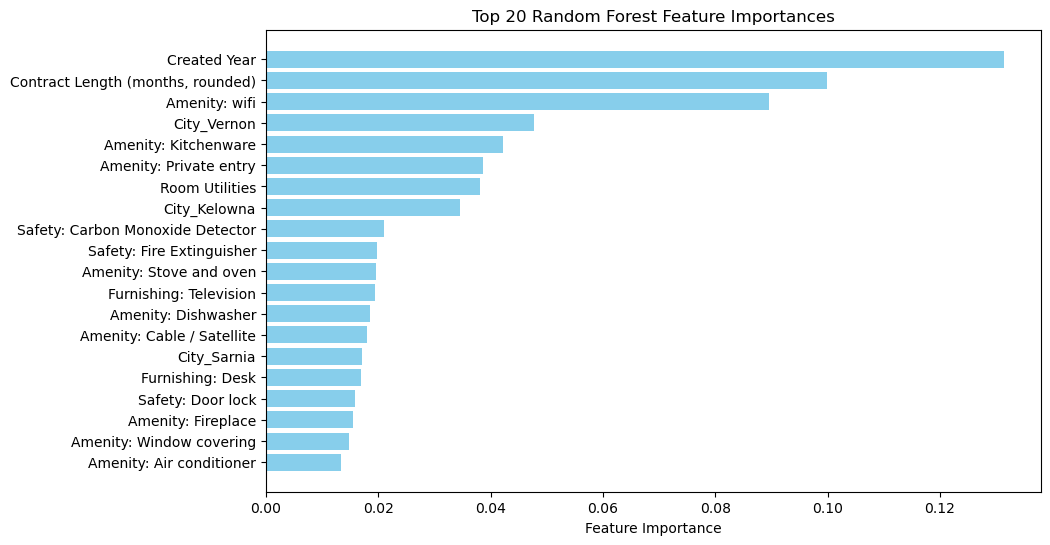

In [269]:


# Get feature importances and corresponding feature names
importances = model_rf.feature_importances_
features = X_train_final.columns

# Create DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort descending and keep top 20
top20 = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top20['Feature'], top20['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance on top
plt.xlabel('Feature Importance')
plt.title('Top 20 Random Forest Feature Importances')
plt.show()


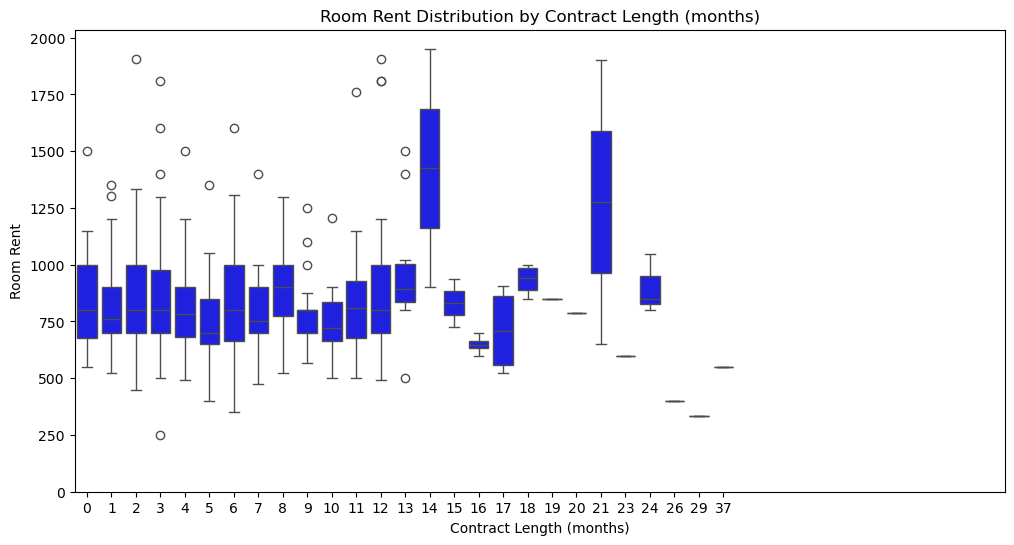

In [325]:
#As contract length was an important feature, let's investigate their distribution 

# Filter out invalid contract lengths (e.g., -1)
contracts_filtered = contracts[contracts['Contract Length (months, rounded)'] >= 0]

plt.figure(figsize=(12, 6))
sns.boxplot(
    x='Contract Length (months, rounded)',
    y='Room Rent',
    data=contracts_filtered,
    color='blue'
)

plt.title('Room Rent Distribution by Contract Length (months)')
plt.xlabel('Contract Length (months)')
plt.ylabel('Room Rent')
plt.ylim(0)  # y-axis starts at 0
plt.xlim(-0.5, contracts_filtered['Contract Length (months, rounded)'].max() + 0.5)  # x-axis starts near 0

plt.show()



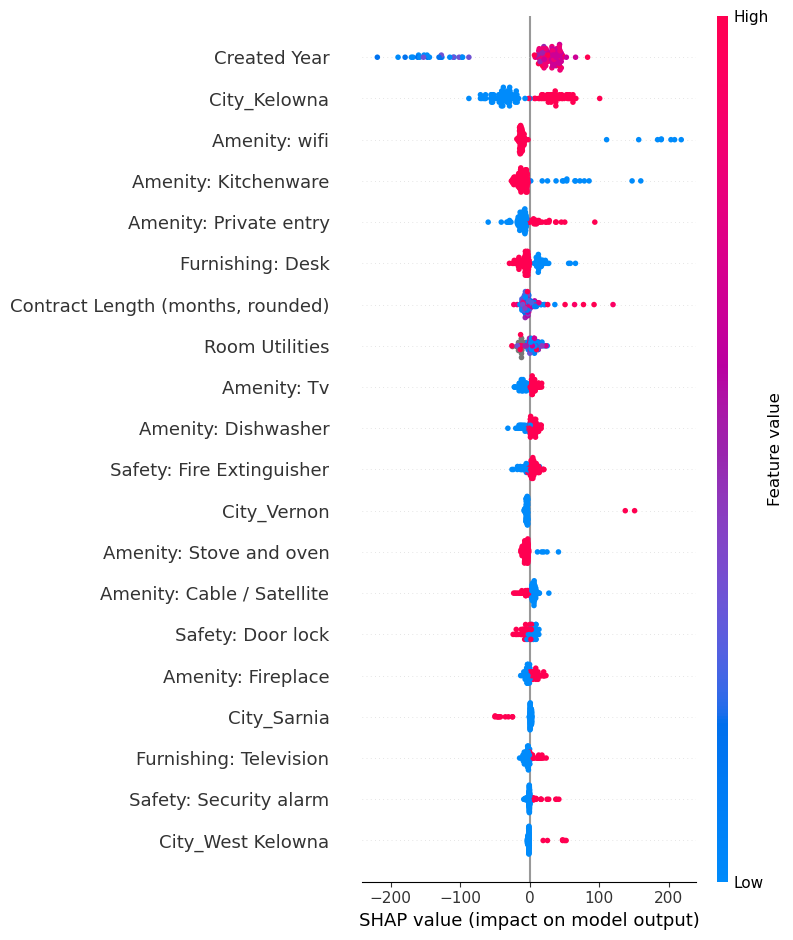

In [273]:

# SHAP model - another tool for understanding feature importance 

# Initialize the SHAP explainer for Random Forest
explainer = shap.Explainer(model_rf, X_train_final)

# Compute SHAP values for the test set
shap_values = explainer(X_test_final)

# Plot SHAP summary for top 20 features
shap.summary_plot(shap_values, X_test_final, max_display=20)



In [279]:
# Optimize random forest model by searching for best parameters 

# Custom RMSE scorer (negative so GridSearch maximizes, as we want to minimize RMSE here)
rmse_scorer = make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)))

# Expanded parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],  # Explicit depths plus unlimited depth
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5]  
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_final, y_train)

best_params = grid_search.best_params_
best_rmse = -grid_search.best_score_

print("Best parameters:", best_params)
print(f"Best CV RMSE: {best_rmse:.4f}")


Fitting 3 folds for each of 405 candidates, totalling 1215 fits
Best parameters: {'max_depth': 15, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV RMSE: 167.4794


In [281]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_final)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"Test RMSE of best RF model: {rmse_test:.4f}")


Test RMSE of best RF model: 134.6187


In [293]:
# --------- Now moving on to LGBM ----------


# Create cleaned copies of dataframes 
X_train_clean = X_train_final.copy()
X_test_clean = X_test_final.copy()

X_train_clean.columns = X_train_clean.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
X_test_clean.columns = X_test_clean.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

# Define the model
lgb_model = LGBMRegressor(
    objective='regression',
    learning_rate=0.1,
    num_leaves=31,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=42,
    n_estimators=500
)

# Fit model with early stopping
lgb_model.fit(
    X_train_clean, y_train,
    eval_set=[(X_test_clean, y_test)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=20)]
)

# Predict and evaluate
y_pred = lgb_model.predict(X_test_clean)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"LightGBM Test RMSE: {rmse:.4f}")

# The warnings are likely due to many zeroes in the dataset but the model is still functioning correctly 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.814076
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.647975
[LightGBM] [Debug] init for col-wise cost 0.000313 seconds, init for row-wise cost 0.000422 seconds
[LightGBM] [Info] Auto-choosing row-wise mult

In [295]:
# Optimize LGBM model by searching for best parameters 

# Define the base LightGBM model 
lgb_model = LGBMRegressor(
    objective='regression',
    random_state=42
)

# Parameter grid for GridSearch
param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 500],
    'feature_fraction': [0.8, 1.0],
    'bagging_fraction': [0.8, 1.0],
    'bagging_freq': [5, 10]
}

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE (negative because sklearn maximizes scores)
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit GridSearch on cleaned training data
grid_search.fit(X_train_clean, y_train)

# Best parameters and CV score
print("Best hyperparameters:", grid_search.best_params_)
print(f"Best CV RMSE: {-grid_search.best_score_:.4f}")

# Train final model with best params on full train data
best_model = LGBMRegressor(**grid_search.best_params_, random_state=42)
best_model.fit(X_train_clean, y_train)

# Predict on test set and calculate RMSE
y_pred = best_model.predict(X_test_clean)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {test_rmse:.4f}")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.814076
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.647975
[LightGBM] [Debug] init for col-wise cost 0.000812 seconds, init for row-wise cos

C:\Users\Foste\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [227]:
import spacy
import pandas as pd
from spacy.matcher import PhraseMatcher

In [231]:
# Attempt to extract more information from the open-text responses using Spacy 

# Load English model
nlp = spacy.load("en_core_web_sm")

contracts_nlp = contracts.copy()

# Clean text column (only use 'Room Title')
contracts_nlp["text_input"] = contracts_nlp["Room Title"].fillna('').str.lower()

# Set up matcher for key features
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [
    "pet", "pets", "no pets", "cat", "dog", "cats", "dogs",
    "transit", "skytrain", "bus", "train",
    "shared bathroom", "private bathroom", "washroom",
    "furnished", "unfurnished",
]
matcher.add("FEATURES", [nlp.make_doc(text) for text in patterns])

# Function to extract features from text
def spacy_extract_features(text):
    doc = nlp(text)
    matches = matcher(doc)
    matched_phrases = set(doc[start:end].text for _, start, end in matches)

    return {
        "mentions_pets": int(any(p in matched_phrases for p in ["pet", "pets", "cat", "dog", "cats", "dogs"]) and "no pets" not in matched_phrases),
        "shared_bathroom": int("shared bathroom" in matched_phrases or "washroom" in matched_phrases),
        "furnished": int("furnished" in matched_phrases and "unfurnished" not in matched_phrases),
        "mentions_transit": int(any(p in matched_phrases for p in [ "transit", "skytrain", "bus", "train"]))
    }

# Apply function to DataFrame
spacy_results = contracts_nlp["text_input"].apply(spacy_extract_features)
features_df = pd.DataFrame(spacy_results.tolist())

# Combine features with original DataFrame
contracts_nlp = pd.concat([contracts_nlp, features_df], axis=1)

# Preview result
contracts_nlp[["Room Title", "mentions_pets", "shared_bathroom", "furnished", "mentions_transit"]].head()


,Room Title,mentions_pets,shared_bathroom,furnished,mentions_transit
0,Close to all amenities! Close to transit!,0.0,0.0,0.0,1.0
1,Close to all amenities! Close to transit!,0.0,0.0,0.0,1.0
2,"Large, open-concept, with private bathroom and...",0.0,0.0,0.0,0.0
3,Room for a UBC student.,0.0,0.0,0.0,0.0
4,Walkout Basement Accomo in Lakeview Heights wi...,0.0,0.0,0.0,0.0


In [233]:
# Show counts of each binary feature
feature_columns = ["mentions_pets", "shared_bathroom", "furnished", "mentions_transit"]

for col in feature_columns:
    print(f"\n{col} value counts:")
    print(contracts_nlp[col].value_counts())

# These results were not very fruitful, but I left them in case you would like to build on them
# You may improve them, or they may become more useful as your dataset grows



mentions_pets value counts:
mentions_pets
0.0    589
1.0      6
Name: count, dtype: int64

shared_bathroom value counts:
shared_bathroom
0.0    582
1.0     13
Name: count, dtype: int64

furnished value counts:
furnished
0.0    466
1.0    129
Name: count, dtype: int64

mentions_transit value counts:
mentions_transit
0.0    564
1.0     31
Name: count, dtype: int64


In [337]:
# ----------- Incorporating data from NLP analyses conducted using Ollama -----------

# Load the second CSV
extracted = pd.read_csv("extracted_contracts.csv")

# Merge extracted data into a new dataframe
contracts_combined = contracts.merge(
    extracted[["ID", "property_size", "bathroom_type", "nearby_amenities"]],
    left_on="Property Id",
    right_on="ID",
    how="left"
)

# Drop duplicate ID column from merged data
contracts_combined.drop(columns=["ID"], inplace=True)

# Clean bathroom_type - standardize to either private, shared, or unknown 
contracts_combined["bathroom_type_clean"] = (
    contracts_combined["bathroom_type"]
    .fillna("unknown")
    .str.lower()
    .str.strip()
    .apply(lambda x: "private" if "private" in x else (
        "shared" if "shared" in x else (
            "unknown" if x == "unknown" else x
        ))
    )
)

# Here I handled a specific exception we had in this dataset - this may or may not be present in future datasets 
contracts_combined["bathroom_type_clean"] = contracts_combined["bathroom_type_clean"].replace({"1.5 bath": "unknown"})

# Step 3: Clean property_size
contracts_combined["property_size"] = contracts_combined["property_size"].fillna("unknown").str.lower().str.strip()

# Step 4: Binarize nearby_amenities as there are many possible values for each home 
contracts_combined["nearby_amenities"] = contracts_combined["nearby_amenities"].fillna("").str.lower().str.strip()
contracts_combined["nearby_amenities_list"] = contracts_combined["nearby_amenities"].str.split(r',\s*')

mlb = MultiLabelBinarizer()
amenities_ohe = pd.DataFrame(
    mlb.fit_transform(contracts_combined["nearby_amenities_list"]),
    columns=[f"amenity: {val}" for val in mlb.classes_],
    index=contracts_combined.index
)

# Add binarized columns to contracts_combined
contracts_combined = pd.concat([contracts_combined, amenities_ohe], axis=1)

# Clean up intermediate list column
contracts_combined.drop(columns=["nearby_amenities_list"], inplace=True)

# Step 5: Set categorical types
contracts_combined["property_size"] = contracts_combined["property_size"].astype("category")
contracts_combined["bathroom_type_clean"] = contracts_combined["bathroom_type_clean"].astype("category")


contracts_combined[["property_size", "bathroom_type", "bathroom_type_clean"]].head()


,property_size,bathroom_type,bathroom_type_clean
0,unknown,unknown,unknown
1,unknown,unknown,unknown
2,large,private,private
3,unknown,unknown,unknown
4,large,private,private


In [339]:
# -------- Adding this data to our random forest model --------

# --- 1. Create working copy of data 
df = contracts_combined.copy()

# --- 2. Prepare target
y = df['Room Rent']

# --- 3. Drop non-feature columns
drop_cols = ['Room Rent', 'Property Id', 'City', 'bathroom_type', 'nearby_amenities']
X = df.drop(columns=drop_cols, errors='ignore')

# --- 4. One-hot encode property_size and bathroom_type_clean (already clean)
cat_features = ['property_size', 'bathroom_type_clean']
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

X_cat = ohe.fit_transform(X[cat_features])
X_cat_df = pd.DataFrame(X_cat, columns=ohe.get_feature_names_out(cat_features), index=X.index)

# Drop original categorical columns before combining
X = X.drop(columns=cat_features)

# --- 5. Keep only numeric/bool features from X
X_numeric = X.select_dtypes(include=['number', 'bool'])

# --- 6. Combine everything
X_final = pd.concat([X_numeric, X_cat_df], axis=1)

# --- 7. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

# --- 8. Train RF model
model_rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model_rf.fit(X_train, y_train)

# --- 9. Predict and evaluate
y_pred = model_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Random Forest RMSE with enhanced features: {rmse:.2f}")
# The output is slightly worse than our other model, probably due to the small sample size 
# However, as your dataset grows this will likely improve 


Random Forest RMSE with enhanced features: 147.86


In [341]:
# ----- Optimize model by searching for best parameters ---------

# opy and set up data
df_grid = contracts_combined.copy()
y_grid = df_grid['Room Rent']

# Drop unneeded columns
drop_cols = ['Room Rent', 'Property Id', 'City', 'bathroom_type', 'nearby_amenities']
X_grid = df_grid.drop(columns=drop_cols, errors='ignore')

# One-hot encode 'property_size' and 'bathroom_type_clean'
cat_features = ['property_size', 'bathroom_type_clean']
ohe_grid = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_cat_grid = ohe_grid.fit_transform(X_grid[cat_features])
X_cat_grid_df = pd.DataFrame(X_cat_grid, columns=ohe_grid.get_feature_names_out(cat_features), index=X_grid.index)

# Drop original categorical columns
X_grid = X_grid.drop(columns=cat_features)

# Keep only numeric/bool for model to use 
X_grid_numeric = X_grid.select_dtypes(include=['number', 'bool'])

# Combine numeric and encoded categorical features
X_grid_final = pd.concat([X_grid_numeric, X_cat_grid_df], axis=1)

# Train/test split
Xg_train, Xg_test, yg_train, yg_test = train_test_split(
    X_grid_final, y_grid, test_size=0.2, random_state=42
)

# Define RMSE scorer as before 
rmse_scorer = make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)))

# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5]
}

# Grid Search CV
rf_grid = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf_grid,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(Xg_train, yg_train)

# Results
best_params = grid_search.best_params_
best_rmse = -grid_search.best_score_

print("\nBest parameters:", best_params)
print(f"Best CV RMSE: {best_rmse:.4f}")


Fitting 3 folds for each of 405 candidates, totalling 1215 fits

Best parameters: {'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV RMSE: 161.8189


In [345]:

# Predict using the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(Xg_test)

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(yg_test, y_pred_best))
print(f"Test RMSE (Best Model): {test_rmse:.4f}")


Test RMSE (Best Model): 140.4382
